In [65]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from typing import Dict

from saturation.simulation import *
from saturation.distributions import *
from saturation.geometry import *
from saturation.plotting import *

In [97]:
def plot_statistics(stats: pd.DataFrame):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

    # Plot crater count
    ax = axes[0][0]
    ax.plot(stats.n_stats_craters, stats.crater_count)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Observable Craters')

    # Plot crater count
    ax = axes[0][1]
    ax.plot(stats.n_stats_craters, stats.areal_density)
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Areal Density')

    # Plot Z statistic
    ax = axes[1][0]
    ax.plot(stats.n_stats_craters, stats.z)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Z Statistic')

    # Plot Za statistic
    ax = axes[1][1]
    ax.plot(stats.n_stats_craters, stats.za)
    ax.axhline(-1.96, color='g', ls='--')
    ax.axhline(1.96, color='g', ls='--')
    ax.axhline(-2.58, color='r', ls='--')
    ax.axhline(2.58, color='r', ls='--')
    ax.set_xlabel('Craters Generated')
    ax.set_ylabel('Za Statistic')

    plt.show()

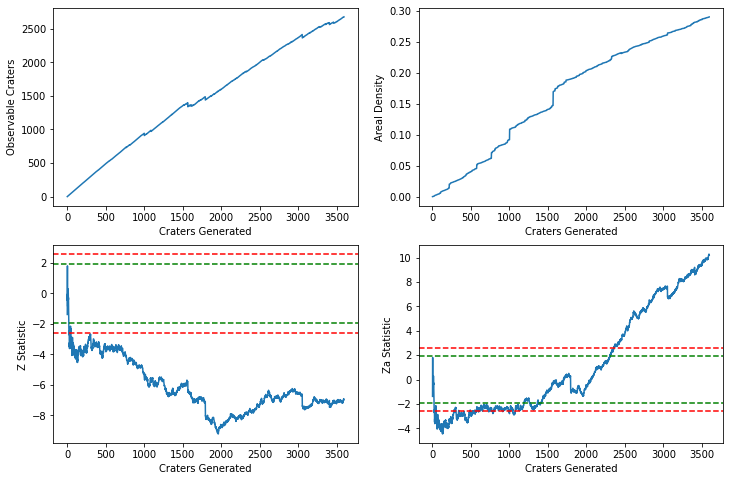

In [98]:
stats = pd.read_csv('/home/mason/output/simulation_run_large_n_craters_0.txt').dropna()
plot_statistics(stats)

In [99]:
stats = pd.read_csv('/home/mason/output/simulation_run_large_n_craters_1.txt').dropna()
plot_statistics(stats)

EmptyDataError: No columns to parse from file

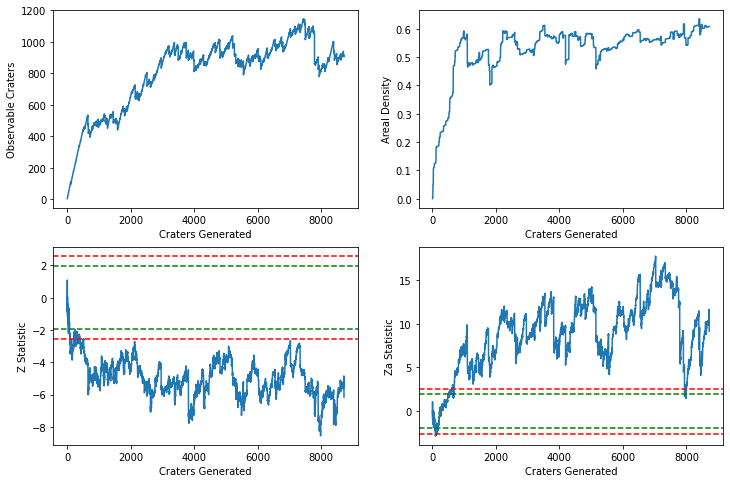

In [100]:
stats = pd.read_csv('/home/mason/output/simulation_run_large_n_craters_2.txt').dropna()
plot_statistics(stats)